In [1]:
ls

3DUnetCNN/                                   resize.ipynb
3D_Unet_ipynb.ipynb                          resize_patch.ipynb
3D_Unet_ipynb.ipynb:Zone.Identifier          result/
3D_Unet_nulti.ipynb                          result_image/
Liver-Segmentation-Using-Monai-and-PyTorch/  sandstone_data_for_ML/
dataset/                                     sandstone_data_for_ML.zip
mri_segment/                                 tutorial122_3D_Unet.ipynb


In [2]:
import tensorflow as tf
#import tensorflow.python.keras as keras
import keras
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [3]:
#Make sure the GPU is available.
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import segmentation_models_3D as sm


Segmentation Models: using `tf.keras` framework.


In [5]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [6]:
import glob
import os
import nibabel as nib
from sklearn.model_selection import train_test_split

def load_nii_files(image_folder, label_folder, max_images=None):
    image_files = sorted(glob.glob(os.path.join(image_folder, "*.nii.gz")))
    label_files = sorted(glob.glob(os.path.join(label_folder, "*.nii.gz")))

    all_images = []
    all_labels = []

    for img_path, lbl_path in zip(image_files, label_files):
        # Load the image and label
        img_obj = nib.load(img_path)
        lbl_obj = nib.load(lbl_path)

        img_data = img_obj.get_fdata()
        lbl_data = lbl_obj.get_fdata()

        all_images.append(img_data)
        all_labels.append(lbl_data)

        # 이미지 개수 제한
        if max_images is not None and len(all_images) >= max_images:
            break

    return all_images, all_labels

# 폴더 경로 지정
image_folder = '/home/chae/segmentation/dataset/ct_train_patch'
label_folder = '/home/chae/segmentation/dataset/ct_label_patch'

# 최대 로드할 이미지 수 지정
max_images_to_load = 100  # 예시로 100개 설정

images, labels = load_nii_files(image_folder, label_folder, max_images_to_load)




In [ ]:

input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

print(input_img.shape)  # n_patches, x, y, z



In [ ]:
train_img = np.stack((input_img,)*3, axis=-1)
train_mask = np.expand_dims(input_mask, axis=4)
unique_values = np.unique(train_mask)
print(unique_values)


In [7]:
# train_img = np.stack((input_img,)*3, axis=-1)
# train_mask = np.expand_dims(input_mask, axis=4)
# unique_values = np.unique(train_mask)
# print(unique_values)


In [9]:
# 레이블 재매핑
def remap_label(label):
    label_mapping = {0: 0,205: 1, 420: 2, 500: 3, 550: 4, 600: 5, 820: 6, 850: 7}
    return label_mapping.get(label, -1)

# 각 트레이닝 이미지와 레이블에 대해 재매핑 적용
train_mask_remap = [np.vectorize(remap_label)(lbl) for lbl in y_train]
test_mask_remap = [np.vectorize(remap_label)(lbl) for lbl in y_test]

# 이미지와 레이블 형태 조정
train_img = [np.stack((img,)*3, axis=-1) for img in X_train]
train_mask = [np.expand_dims(lbl, axis=-1) for lbl in train_mask_remap]

test_img = [np.stack((img,)*3, axis=-1) for img in X_test]
test_mask = [np.expand_dims(lbl, axis=4) for lbl in test_mask_remap]


AxisError: axis 4 is out of bounds for array of dimension 4

In [ ]:
# 훈련 및 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Number of training images: {len(X_train)}")
print(f"Number of testing images: {len(X_test)}")

In [ ]:

# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


Backbones: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']

In [ ]:
#Define parameters for our model.

encoder_weights = 'imagenet'
BACKBONE = 'vgg16'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
patch_size = 64
n_classes = 8
channels=1

LR = 0.00001
optim = tf.keras.optimizers.Adam(LR)


# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25, 0.25, 0.25,0.25, 0.25, 0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
type(X_train)
type(X_test)
print(X_test[0].shape)
print(X_train[0].shape)


(64, 64, 64)
(64, 64, 64)


In [ ]:
type(X_train)

list

In [ ]:
# #리스트 형태의 이미지 데이터를 NumPy 배열로 변환하고 채널 차원 추가
# X_train_np = np.array(X_train)[..., np.newaxis]
# X_test_np = np.array(X_test)[..., np.newaxis]
# y_train = np.array(y_train)[..., np.newaxis]
# y_test = np.array(y_test)[..., np.newaxis]
# # 전처리 함수 적용
# X_train_prep = preprocess_input(X_train_np)
# X_test_prep = preprocess_input(X_test_np)


In [ ]:
def expand_channels(image):
    return np.stack((image,)*3, axis=-1)

X_train_expanded = [expand_channels(x) for x in X_train]
X_test_expanded = [expand_channels(x) for x in X_test]

X_train_expanded = np.array(X_train_expanded)
X_test_expanded = np.array(X_test_expanded)

# y_train과 y_test에 대해서는 채널 확장을 적용하지 않습니다.
y_train_expanded = np.expand_dims(y_train, axis=-1)
y_test_expanded = np.expand_dims(y_test, axis=-1)

X_train_prep = preprocess_input(X_train_expanded)
X_test_prep = preprocess_input(X_test_expanded)

# y_train_prep과 y_test_prep은 y_train_expanded와 y_test_expanded를 그대로 사용합니다.
y_train_prep = y_train_expanded
y_test_prep = y_test_expanded


In [ ]:
print(images[0].shape)

(64, 64, 64)


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12140269055754630421
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7745830912
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12951131836840068588
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:2b:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [ ]:
#Define the model. Here we use Unet but we can also use other model architectures from the library.
model = sm.Unet(BACKBONE, classes=n_classes,
                input_shape=(patch_size, patch_size, patch_size, 3),
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv3D)          (None, 64, 64, 64,   5248        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv3D)          (None, 64, 64, 64,   110656      ['block1_conv1[0][0]']           
                                64)                                                           

In [ ]:
print(f"X_train shape: {np.array(X_train_prep).shape}")
print(f"y_train shape: {np.array(y_train).shape}")
print(f"X_test shape: {np.array(X_test).shape}")
print(f"y_test shape: {np.array(y_test).shape}")


X_train shape: (80, 64, 64, 64, 3)
y_train shape: (80, 64, 64, 64)
X_test shape: (20, 64, 64, 64)
y_test shape: (20, 64, 64, 64)


In [ ]:
y_train_prep

array([[[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         ...,

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          ...,
          [0.],


In [ ]:
#Fit the model
history=model.fit(X_train_prep,
          y_train,
          batch_size=1,
          epochs=25,
          verbose=1,
          validation_data=(X_test_prep, y_test))

ValueError: Data cardinality is ambiguous:
  x sizes: 80
  y sizes: 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64
Make sure all arrays contain the same number of samples.

In [ ]:
#Save model for future use
model.save('/home/chae/segmentation/result/3D_mrmodel_vgg16_30epochs.h5')

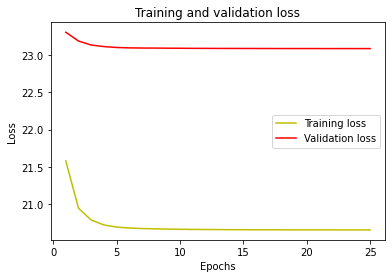

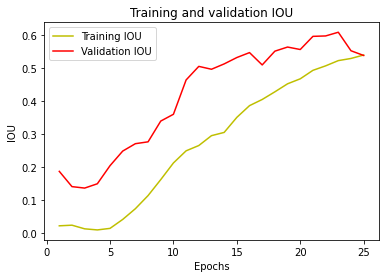

In [ ]:
###
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# # import numpy as np
# # import nibabel as nib
# # import tensorflow as tf
# # import segmentation_models as sm

# # 여기에 dice_coefficient 및 dice_coefficient_loss 함수 정의

# # 모델을 불러올 때 사용할 custom_objects
# custom_objects = {
#     'dice_loss_plus_1focal_loss': lambda y_true, y_pred: sm.losses.DiceLoss() + sm.losses.CategoricalFocalLoss(),
#     'dice_coefficient': dice_coefficient,
#     'dice_coefficient_loss': dice_coefficient_loss,
#     'DiceLoss': sm.losses.DiceLoss,
#     'CategoricalFocalLoss': sm.losses.CategoricalFocalLoss,
#     'iou_score': sm.metrics.IOUScore,
#     'f1-score': sm.metrics.FScore
# }

# # 모델 불러오기
# model = tf.keras.models.load_model('/home/chae/segmentation/result/3D_model_vgg16_100epochs.h5', custom_objects=custom_objects)

# resized_image_data = zoom(downsized_image_data, (64 / downsized_image_data.shape[0], 64 / downsized_image_data.shape[1], 64 / downsized_image_data.shape[2]))

# # 채널 차원 추가 (회색조 이미지를 3채널로 변환)
# resized_image_data = np.stack((resized_image_data,)*3, axis=-1)

# # 배치 차원 추가
# resized_image_data = np.expand_dims(resized_image_data, axis=0)

# # 모델 적용
# segmented = model.predict(resized_image_data)
# # 모델 적용

# # 결과 처리
# segmented_result = np.argmax(segmented, axis=-1)
# segmented_result = np.squeeze(segmented_result)

# # 데이터 타입을 float32 또는 int16으로 변환
# segmented_result = segmented_result.astype(np.float32)  # 또는 np.int16

# # NIfTI 파일로 저장
# new_nii = nib.Nifti1Image(segmented_result, affine=np.eye(4), dtype=np.float32)  # affine 매트릭스는 예시입니다
# nib.save(new_nii, 'segmented_output.nii')

In [ ]:
# import itk
# import h5py
# import numpy as np

# # H5 파일 읽기
# with h5py.File('/home/chae/segmentation/result/3D_model_vgg16_100epochs.h5', 'r') as file:
#     dataset = file['/home/chae/segmentation/dataset/ct_test/ct_test_2001_image.nii.gz']
#     image_data = np.array(dataset)

# # ITK 이미지로 변환
# image_itk = itk.image_from_array(image_data)

# # ITK 이미지 처리 예시 (예: 스무딩)
# smoothed_image = itk.smoothing_recursive_gaussian_image_filter(image_itk, sigma=2.0)

# # 결과 저장 또는 추가 처리


In [ ]:
type(X_test)
len(X_test)
type(X_test[0])
print(f"X_test shape: {np.array(X_test).shape}")
print(f"y_test shape: {np.array(y_test).shape}")
print("X_train_prep shape: ", X_train_prep.shape)
print("y_train shape: ", y_train_prep.shape)
print("X_test_prep shape: ", X_test_prep.shape)
print("y_test shape: ", y_test_prep.shape)

X_test shape: (200, 64, 64, 64)
y_test shape: (200, 64, 64, 64)
X_train_prep shape:  (800, 64, 64, 64, 3)
y_train shape:  (800, 64, 64, 64, 1)
X_test_prep shape:  (200, 64, 64, 64, 3)
y_test shape:  (200, 64, 64, 64, 1)


In [ ]:
#Predict on the test data
from keras.models import load_model
my_model = load_model('/home/chae/segmentation/result/3D_mrmodel_vgg16_30epochs.h5', compile=False)
y_pred=my_model.predict(X_test_prep)
y_pred_argmax=np.argmax(y_pred, axis=4)#4
y_test_argmax = np.argmax(y_test, axis=4)#4


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block1_pool/MaxPool3D' defined at (most recent call last):
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 619, in start
      self.io_loop.start()
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
      self.asyncio_loop.run_forever()
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
      ret = callback()
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
      return fn(*args, **kwargs)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
      self.run()
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
      yielded = self.gen.send(value)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 358, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
      yielded = next(result)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
      yielded = next(result)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 538, in execute_request
      user_expressions, allow_stdin,
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
      yielded = next(result)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3029, in _run_cell
      return runner(coro)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3472, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-31-af7247416c92>", line 4, in <module>
      y_pred=my_model.predict(X_test_prep)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/engine/training.py", line 1982, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/engine/training.py", line 1801, in predict_function
      return step_function(self, iterator)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/engine/training.py", line 1790, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/engine/training.py", line 1783, in run_step
      outputs = model.predict_step(data)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/engine/training.py", line 1751, in predict_step
      return self(x, training=False)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/engine/functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/chae/anaconda3/envs/segment/lib/python3.7/site-packages/keras/layers/pooling.py", line 703, in call
      padding=self.padding.upper())
Node: 'model/block1_pool/MaxPool3D'
OOM when allocating tensor with shape[32,64,32,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block1_pool/MaxPool3D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_5991]

In [ ]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))

(200, 64, 64, 64)
(200, 64, 64)
[0 1 2 3 4 5 6 7]


In [ ]:
# Using built in keras function for IoU
# Only works on TF > 2.0
from keras.metrics import MeanIoU
from keras.metrics import MeanIoU
n_classes = 8
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

InvalidArgumentError: `labels` out of bound
Condition x < y did not hold.
First 3 elements of x:
[0 0 0]
First 1 elements of y:
[8]

In [ ]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
print(test_prediction1.shape)




(32, 32, 32)


In [ ]:
ground_truth_argmax = np.argmax(ground_truth, axis=3)
print(test_img.shape)

(32, 32, 32, 3)


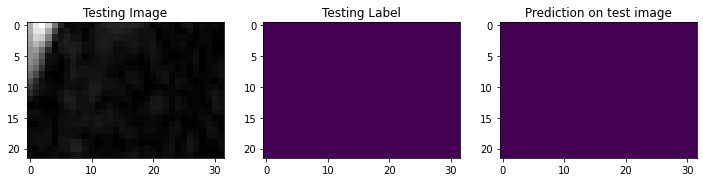

In [ ]:
#Plot individual slices from test predictions for verification
slice =22
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:slice,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth_argmax[slice,:slice,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:slice,:])
plt.show()

Now segment the full volume using the trained model.

In [ ]:
large_image_path = '/home/chae/segmentation/dataset/mr_train/mr_train_1001_image.nii.gz'
large_image_obj = nib.load(large_image_path)
large_image_data = large_image_obj.get_fdata()
print("imageshpae: ",large_image_data.shape)
img_patches = patchify(large_image_data, (patch_size,patch_size,patch_size), step=stepsize)  #Step=64 for 64 patches means no overlap
print(large_image_data.shape)
print(img_patches.shape)

imageshpae:  (512, 512, 160)
(512, 512, 160)
(16, 16, 5, 32, 32, 32)


In [ ]:
# import numpy as np
# import nibabel as nib
# from patchify import patchify, unpatchify

# # 원본 이미지 데이터 로드
# image_path = '/home/chae/segmentation/dataset/ct_train/ct_train_1001_image.nii.gz'
# image_obj = nib.load(image_path)
# image_data = image_obj.get_fdata()

# # 원본 이미지 크기
# original_shape = image_data.shape

# # 패치 크기
# patch_size = 64

# # 필요한 패딩 계산
# padding = [(0, PS - (dim % PS)) for dim, PS in zip(original_shape, (patch_size, patch_size, patch_size))]
# padding = [(pad[0], max(pad[1], 0)) for pad in padding]  # 음수 패딩 방지

# # 이미지에 패딩 추가
# padded_image = np.pad(image_data, padding, mode='constant', constant_values=0)

# # 패딩된 이미지로 패치 생성
# img_patches = patchify(padded_image, (patch_size, patch_size, patch_size), step=patch_size)

# # 여기서 모델을 사용하여 예측을 수행하고, 예측된 패치를 얻습니다.
# # 예측된 패치를 재구성
# reconstructed_image = unpatchify(img_patches, padded_image.shape)

# # 원본 이미지 크기로 잘라내기
# reconstructed_image = reconstructed_image[:original_shape[0], :original_shape[1], :original_shape[2]]

# # 결과 확인
# print("Reconstructed image shape:", reconstructed_image.shape)
# print("padded_image shape:", padded_image.shape)


In [ ]:
# Predict each 3D patch
predicted_patches = []
for i in range(img_patches.shape[0]):
  for j in range(img_patches.shape[1]):
    for k in range(img_patches.shape[2]):
      #print(i,j,k)
      single_patch = img_patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_prediction = my_model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)



In [ ]:
#Convert list to numpy array
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(1280, 32, 32, 32)


In [ ]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches,
                                        (img_patches.shape[0], img_patches.shape[1], img_patches.shape[2],
                                         img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]) )
print(predicted_patches_reshaped.shape)

(16, 16, 5, 32, 32, 32)


In [ ]:
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image_data.shape)
print(reconstructed_image.shape)

(512, 512, 160)


In [ ]:
# #when size unfit
# import numpy as np
# from patchify import unpatchify

# # 예시: predicted_patches_reshaped의 형태가 (8, 8, 5, 64, 64, 64)
# # 세 번째 차원(5)에서 마지막 패치를 제외하고 나머지 패치를 사용합니다.
# desired_shape = (512, 512, 160)
# reconstructed_image_resized = np.zeros(desired_shape)
# reconstructed_image_resized[:,:,:] = large_image_data[:,:,:160]

# # 마지막 패치를 제외한 패치 배열을 선택
# selected_patches = predicted_patches_reshaped[:, :, :, :, :, :]

# # 재구성된 이미지 생성
# # large_image_data.shape는 원본 이미지의 크기를 나타냅니다.
# reconstructed_image = unpatchify(selected_patches, reconstructed_image_resized.shape)

# print("Reconstructed image shape:", reconstructed_image.shape)


In [ ]:
print(reconstructed_image.dtype)

int64


In [ ]:
#Convert to uint8 so we can open image in most image viewing software packages
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

uint8


In [ ]:
import os
original_nii = nib.load('/home/chae/segmentation/dataset/mr_train/mr_train_1001_image.nii.gz')

# 재구성된 이미지를 NIfTI 형식으로 저장
new_nii = nib.Nifti1Image(reconstructed_image, original_nii.affine, original_nii.header)

# 저장할 경로 지정
save_path = '/home/chae/segmentation/result_image/'

# 해당 경로에 폴더가 없으면 생성
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 파일 저장
nib.save(new_nii, os.path.join(save_path, 'mr_segmented.nii'))

print("Segmented NIfTI file saved at:", os.path.join(save_path, 'mr_segmented.nii'))

Segmented NIfTI file saved at: /home/chae/segmentation/result_image/mr_segmented.nii


In [ ]:
#If you would like to save the volume as multichannel dataset....

In [ ]:
print(np.unique(reconstructed_image))

[0 1 2 3 4 5 6]


In [ ]:
# #Seperate each channel/segment to be combined as multiple channels.
# num_segments=4
# segm0 = (reconstructed_image == 0)
# segm1 = (reconstructed_image == 1)
# segm2 = (reconstructed_image == 2)
# segm3 = (reconstructed_image == 3)

# final = np.empty((reconstructed_image.shape[0], reconstructed_image.shape[1], reconstructed_image.shape[2], num_segments))
# final[:,:,:,0] = segm0
# final[:,:,:,1] = segm1
# final[:,:,:,2] = segm2
# final[:,:,:,3] = segm3

In [ ]:
# #Use APEER OMETIFF library to read and write multidimensional images
# !pip install imagecodecs==2020.5.30
# !pip install --upgrade setuptools wheel
# !pip install apeer-ometiff-library --no-deps


In [ ]:
# from apeer_ometiff_library import io

In [ ]:
# # Expand image array to 5D of order (T, Z, C, X, Y)
# # This is the convention for OMETIFF format as written by APEER library
# final = np.expand_dims(final, axis=0)
# final=np.swapaxes(final, 2, 4)

# final = final.astype(np.int8)



In [ ]:
# print("Shape of the segmented volume is: T, Z, C, X, Y ", final.shape)
# print(final.dtype)


In [ ]:
# # Write dataset as multi-dimensional OMETIFF *image*
# io.write_ometiff("/content/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/segmented_multi_channel.ome.tiff", final)